<a href="https://colab.research.google.com/github/yohanesnuwara/CO2Inject/blob/master/main/rock_physics_modelling_co2injection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Physics Modelling of CO2 Injection in Carbonate

This notebook runs a rock physics modelling to predict the elastic (seismic) response of a carbonate rock to injected CO2. 

# 1. Setting Up

In [0]:
# basic libraries
import numpy as np
import matplotlib.pyplot as plt

Clone from my github repository: CO2Inject

In [3]:
! git clone https://github.com/yohanesnuwara/CO2Inject/

Cloning into 'CO2Inject'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 60 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [0]:
import sys
sys.path.append('./CO2Inject/lib')

# 2. Compute Properties of Rock Matrix

Properties of rock matrix include: bulk modulus (K), shear modulus (G), and density (rho). 

Input:

In [0]:
rhocalc = 2.71; Kcalc = 76.8; Gcalc = 32
rhoclay = 2.58; Kclay = 20.9; Gclay = 6.9
rhodolo = 2.87; Kdolo = 94.9; Gdolo = 45
rhoqtz = 2.65; Kqtz = 36.6; Gqtz = 45
# mineral composition
calc = 0.4; clay = 0.24; dolo = 0.34; qtz = 0.02

Mineral composition (fraction of calcite, clay, dolomite, and quartz) is estimated from petrophysical analysis (rhomaa, dtmaa, umaa crossplot). [See my another notebook](https://). 

Voigt-Reuss-Hill (VRH) computation:

In [45]:
mincomposition = np.array([calc, clay, dolo, qtz])
rhomineral = np.array([rhocalc, rhoclay, rhodolo, rhoqtz])
Kmineral = np.array([Kcalc, Kclay, Kdolo, Kqtz])
Kmineral_inv = 1 / Kmineral
Gmineral = np.array([Gcalc, Gclay, Gdolo, Kqtz])
Gmineral_inv = 1 / Gmineral

Kv = sum(mincomposition * Kmineral)
Kr_inv = sum(mincomposition * Kmineral_inv)
Gv = sum(mincomposition * Gmineral)
Gr_inv = sum(mincomposition * Gmineral_inv)
rhom = sum(mincomposition * rhomineral)
Km = (Kv+(1/Kr_inv)) / 2
Gm = (Gv+(1/Gr_inv)) / 2
Km, Gm, rhom # in GPa

(58.38150053888909, 24.271778274276585, 2.732)

# 3. Saturation and Pressure Change

Pressure is an important information for further rock physics modelling. The case that is presented here is **CO2 injection that lasts for 10 years with rate of 800 ton/day of CO2**. Simulation shows that reservoir pressure declines (blue curve). 

![alt text](https://drive.google.com/uc?id=1U0oIG4OCQwvQaCUhr1hFb3AuuQ3jEZ5F)

From simulation, until 10 years, the **maximum CO2 saturation achieves 50%** (high residual water saturation in carbonate system). Pressure declines **from 27.3 MPa to 15.9 MPa**.  

In [0]:
year = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # start year is year 0, end year is year 10
SW = [1,	0.95,	0.9,	0.85,	0.8,	0.75,	0.7,	0.65,	0.6,	0.55,	0.5] # water saturation
Pp = [27.3,	26.16,	25.02,	23.88,	22.74,	21.6,	20.46,	19.32,	18.18,	17.04,	15.9] # reservoir pressure

According to Hiltermann (2000), reduced brine saturation and reduced pore pressure causes decrease in P-velocity.

# 4. Rock Physics Computation

This will compute how much P-velocity (Vp), S-velocity (Vs), and density of carbonate rock change as effect of CO2 injection from year 1 to year 10. 


Steps:
1. Compute **density and bulk modulus of brine** using Batzle and Wang (1992). Using `Batzle_and_Wang.py`. Inputs required: reservoir pressure (P), temperature (T), and brine salinity. Result: brine density and bulk modulus computed for each pressure.

2. Compute **density and bulk modulus of CO2** using Span and Wagner (1998). Using `EOS_CO2.py`. Inputs required: reservoir P, T. Result: CO2 density and bulk modulus computed for each pressure.

3. Mixing brine and CO2, using **Brie (intermediate patchy) mixing** because of vug porosity. For each composition `Sw` brine and `(1-Sw)` CO2. Result: density and bulk modulus of brine + CO2.

**Change of pressure affects change of fluid properties**

Last step: **Kuster-Toksoz (1974) modelling** 

To compute Vp, Vs, and density. Using `Kuster_Toksoz_2.py`.
Inputs required:


1. **Matrix**: matrix bulk modulus (Km), shear modulus (Gm)

2. **Fluid**: brine + CO2 bulk modulus (Kf), shear modulus (Gf = 0)

3. **Pore**: Pore is pretty complicated, because of pore geometry. Carbonate has various types of pores, so pore types must be determined using Xu and Payne (2009) modelling. [See my another notebook](https://). For this case, the pore types already calculated. 

![alt text](https://drive.google.com/uc?id=1HkESSk1KEiRCqE3f1vw84ylzfO7wUi7f)

**Effective porosity**: 14%

**Pore aspect ratio**: α Reference = 0.15, α Crack = 0.02, α Stiff = 0.8

**Pore composition**: 60% Reference + Stiff pore, 40% Reference + Crack pore

# Implementation:

Import functions:

In [0]:
import Batzle_and_Wang
import Kuster_Toksoz_2
import EOS_CO2
from Batzle_and_Wang import BW_brine_density, BW_brine_bulk
from Kuster_Toksoz_2 import stuffs, PQ, KusterToksoz
from EOS_CO2 import EOS

Input:

In [0]:
# fluid input
temp = 158 # reservoir temperature
salinity = 0.011

# Xu-Payne pore
totalporo = 0.14

alpha1 = 0.15  # aspect ratio of 1st pore
alpha2 = 0.8  # aspect ratio of 2nd pore
compos1 = 0.6  # composition of 1st pore relative to total poro
compos2 = 0.4  # composition of 2nd pore relative to total poro

Run: 

In [0]:
CO2_sat = []
Vp_sat = []
Vs_sat = []
rho_sat = []

for i in range(len(SW)):
    # Step 1. calculation of brine properties
    rhobrine = BW_brine_density(temp, Pp[i], salinity)
    Kbrine = BW_brine_bulk(temp, Pp[i], salinity, rhobrine)
    Gbrine = 0
    # result: brine density calculated for each pressure

    # Step 2. calculation of CO2 properties
    rhoCO2_post = EOS(Pp[i], temp)[0]
    KCO2_post = EOS(Pp[i], temp)[1]

    # Step 3. calculation of mixed fluid properties, use brie mixing rule
    e = 2
    SCO2 = 1 - SW[i]
    rho_inj = (SCO2 * rhoCO2_post) + (SW[i] * rhobrine)
    Kf_inj = ((Kbrine - KCO2_post) * (SW[i] ** e)) + KCO2_post
    Gf_inj = 0

    # Step 4. calculation of saturated Vp, Vs, rho, use Kuster-Toksoz
    stuffs1_inj = stuffs(Km, Kf_inj, Gm, Gf_inj, totalporo, compos1, alpha1)
    stuffs2_inj = stuffs(Km, Kf_inj, Gm, Gf_inj, totalporo, compos2, alpha2)

    ci_1_inj = stuffs1_inj[4]
    ci_2_inj = stuffs2_inj[4]

    PQ_1_inj = PQ(stuffs1_inj[0], stuffs1_inj[1], stuffs1_inj[2], stuffs1_inj[5], stuffs1_inj[6])
    PQ_2_inj = PQ(stuffs2_inj[0], stuffs2_inj[1], stuffs2_inj[2], stuffs2_inj[5], stuffs2_inj[6])

    sigma_P_inj = (ci_1_inj * PQ_1_inj[0]) + (ci_2_inj * PQ_2_inj[0])
    sigma_Q_inj = (ci_1_inj * PQ_1_inj[1]) + (ci_2_inj * PQ_2_inj[1])

    KusTok_inj = KusterToksoz(sigma_P_inj, sigma_Q_inj, Km, Gm, Kf_inj, rhom, rho_inj)
    rho_post = KusTok_inj[2]; Vp_post = KusTok_inj[3] * 1000; Vs_post = KusTok_inj[4] * 1000

    SCO2 = SCO2 * 100
    CO2_sat.append(float(SCO2))
    Vp_sat.append(float(Vp_post))
    Vs_sat.append(float(Vs_post))
    rho_sat.append(float(rho_post))

Visualize curve of Vp, Vs, and density change as effect of CO2 saturation and declining pressure

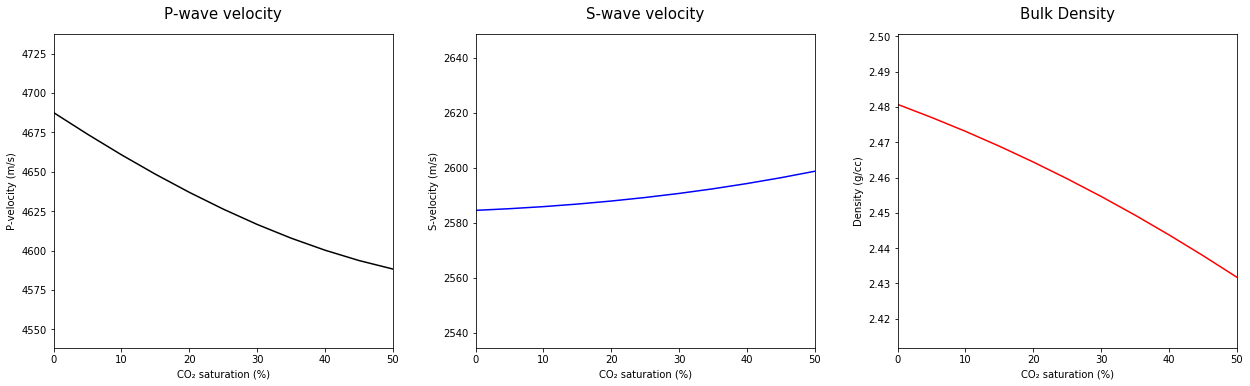

In [77]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(CO2_sat, Vp_sat, color='black')
plt.title('P-wave velocity', size=15, pad=15)
plt.xlim(0, 50)
plt.ylim((min(Vp_sat)-50), (max(Vp_sat)+50))
plt.xlabel('CO\u2082 saturation (%)'); plt.ylabel('P-velocity (m/s)')

plt.subplot(1,3,2)
plt.plot(CO2_sat, Vs_sat, color='blue')
plt.title('S-wave velocity', size=15, pad=15)
plt.xlim(0, 50)
plt.ylim((min(Vs_sat)-50), (max(Vs_sat)+50))
plt.xlabel('CO\u2082 saturation (%)'); plt.ylabel('S-velocity (m/s)')

plt.subplot(1,3,3)
plt.plot(CO2_sat, rho_sat, color='red')
plt.title('Bulk Density', size=15, pad=15)
plt.xlim(0, 50)
plt.ylim((min(rho_sat)-0.02), (max(rho_sat)+0.02))
plt.xlabel('CO\u2082 saturation (%)'); plt.ylabel('Density (g/cc)')

plt.tight_layout(pad=3)
plt.show()

**Calculate percent of reduce of Vp, Vs, and density**

In [74]:
# print(((Vp_sat[0]-min(Vp_sat))/Vp_sat[0]) * 100)
# print(((max(Vs_sat)-min(Vs_sat))/min(Vs_sat)) * 100)
# print(((max(rho_sat)-min(rho_sat))/max(rho_sat)) * 100)

(4588.277977768951, 4687.599637958713)